In [ ]:
#conda env export > environment.yml

replace contractions/location abbreviations via dictionary
denoise text/apply word segmentation
create word count dictionary
next, spell check:
add to dictionary from reoccuring words in text? or use freq dict symspell
apply spell check to words in word count dictionary occuring only one time
apply pos tag to tweets creating new column
lemmatize tweets based on pos tag column
bigrams with Phraser

In [3]:
import os
import re
import string
import pandas as pd 
import itertools

## import datasets

In [30]:
# import dataset
train = pd.read_csv('train.csv', usecols=['text', 'keyword', 'location'])
test = pd.read_csv('test.csv', usecols=['text', 'keyword', 'location'])
target = pd.read_csv('train.csv', usecols=['target'])

In [23]:
print(len(train))

7613


In [24]:
print(len(test))

3263


In [25]:
df = train.append(test)

In [27]:
len(df)

10876

## visualize target data

#dups = df[df.duplicated(['text'])]
df.drop_duplicates(subset=['text', 'location', 'keyword'], keep='first', inplace=True)
#test_df.drop_duplicates(subset=['text'], keep='first', inplace=True)

print(len(df))
#print(len(test_df))

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='solarizedl')

Text(0.5, 1.0, 'Binary Distribution of Disaster Tweet Dataset')

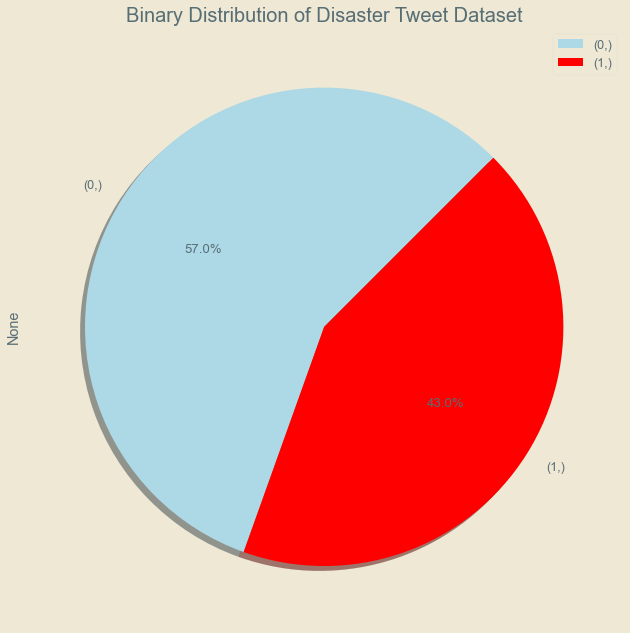

In [31]:
# visualize distribution of target in dataset
plt.figure(figsize=(11,11))
colors = ['lightblue', 'red']
expl = (0, 0.1)
target.value_counts().plot(kind='pie', legend=True, startangle=45, shadow=True, 
                             colors=colors, autopct='%1.1f%%')
plt.title('Binary Distribution of Disaster Tweet Dataset', fontsize=20)

# clean and process text

In [68]:
from symspellpy.symspellpy import SymSpell, Verbosity
from spellchecker import SpellChecker
import pkg_resources

## hashtags

In [74]:

# functions related to expanded hashtags in text
def pascal_case_split(text):
    # expand hashtags formatted in pascal case, ex: #ThisIsPascal
    return re.sub(r'([A-Z])([?=a-z0-9+])', r' \1\2', text)

def camel_case_split(text):
    # expand hashtags formatted in pascal case, ex: #thisIsCamel
    return re.sub(r'([a-z0-9+])([?<=A-Z])', r'\1 \2', text)

def spell_check_word(word):
    # lookup suggestions for individual words
    spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=5)
    dictionary_path = pkg_resources.resource_filename(
                      "symspellpy", "frequency_dictionary_en_82_765.txt")
    spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    corrections = spell.lookup(word, Verbosity.TOP, include_unknown=True)
    closest = corrections[0]
    # display suggestion term, edit distance, and term frequency
    return closest.term
    
def spell_check_words(word):
    # lookup suggestions for multi word string input
    spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=5)
    dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
    bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
    spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)
    corrections = spell.lookup_compound(word, max_edit_distance=2)
    closest = corrections[0]
# display suggestion term, edit distance, and term frequency
    return closest.term

def desegment_strings(text):
    spell = SymSpell(max_dictionary_edit_distance=0)
    dictionary_path = pkg_resources.resource_filename("symspellpy","frequency_dictionary_en_82_765.txt")
    spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    if text.isupper() | text.islower() and text.startswith('#'):
        result = spell.word_segmentation(text)
        text = result.corrected_string
    return text 

def remove_hash(text):
    # remove hash symbol in front of hashtag text and remove non unicode chars
    return re.sub('#', '', text)

def expand_strings(text):
    # desegment hashtags & other strings with similar formatting
    text = re.sub('CAfire', 'california fire', text)
    c_text = camel_case_split(text)
    p_text = pascal_case_split(c_text)
    h_text = remove_hash(p_text)
    return h_text

def expand_strings_sc(text):
    # combine hashtag split functions for specific cases and remove hash, spell check using compound lookup
    c_text = camel_case_split(text)
    p_text = pascal_case_split(c_text)
    lu_text = spell_check_words(p_text)
    h_text = remove_hash(lu_text)
    return h_text

def expand_strings_ds(text):
    # combine hashtag split functions for specific cases and remove hash. spell check using wordsegmentation
    c_text = camel_case_split(text)
    p_text = pascal_case_split(c_text)
    lu_text = desegment_strings(p_text)
    h_text = remove_hash(lu_text)
    return h_text

def expand_strings_indv_word(text):
    # combine hashtag split functions for specific cases and remove hash. spell check using wordsegmentation
    c_text = camel_case_split(text)
    p_text = pascal_case_split(c_text)
    lu_text = spell_check_word(p_text)
    h_text = remove_hash(lu_text)
    return h_text

# def expand_strings_ds(text):
#     # combine hashtag split functions for specific cases and remove hash
#     c_text = camel_case_split(text)
#     p_text = pascal_case_split(c_text)
#     lu_text = desegment_hashtag(p_text)
#     h_text = remove_hash(lu_text)
#     return h_text

In [70]:
# create column for extracted hashtags
df['hashtags'] = df.text.str.findall(r'(?:(?<=\s)|(?<=^))#.*?(?=\s|$)')
#test_df['hashtags'] = test_df.text.str.findall(r'(?:(?<=\s)|(?<=^))#.*?(?=\s|$)')
df.hashtags = df.hashtags.astype(str)
#test_df.hashtags = test_df.hashtags.astype(str)

%time
df['exp_hash'] = df['hashtags'].map(expand_hashtags)

In [ ]:
df.location.unique()


%time
# with desegment_hashtag
df['exp_hash'] = df['hashtags'].map(expand_strings)

# process text

## dictionary based word replacement 

In [33]:
import csv

In [98]:
# import and read previously created dictionary as csv for abbreviations and expansions of words
def csv2dict(csv_name):
    with open(csv_name, mode='r') as f:
        reader = csv.reader(f)
        next(reader)
        return {rows[1]:rows[2] for rows in reader}
location_expansion_dict = csv2dict('utils\location_expansion.csv')
contractions_dict = csv2dict('utils\contractions.csv')
initialisms_dict = csv2dict('utils\initialisms.csv')

## denoise text functions

In [35]:
import html

In [71]:
def word_expansion_from_dict(text, expansion_dict):
    c_re = re.compile(r'\b'+r'\b|\b'.join(map(re.escape, expansion_dict.keys()))+r'\b')
    def replace(match):
        expansion =  f"{expansion_dict[match.group(0)]}"
        return expansion
    text = c_re.sub(replace, text)
    return text

def reduce_repeat_vowels(text, keep_reps=1):
    # function to reduce repeated vowel occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    vowels = ['a','e','i','o','u']
    for ch in iter(vowels):
        text = re.sub(r'(?i)'+rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text

def reduce_repeat_consonants(text, keep_reps=2):
    # function to reduce repeated consonant occurences in string, 
    # keep_reps argument as int refers to number of occurences to keep in string
    # keep_reps argument default : 1, can be set to any integer
    consonants = ['b','c','d','f','g','h','j','k','l','m','n','p','q','r','s','t','v','w','x','y','z']
    for ch in iter(consonants):
        text = re.sub(r'(?i)'+ rf'([{ch}])'+r'{3,}', r'\1'*int(keep_reps), text)
    return text
    
def remove_urls(text):
    # function to remove urls from string
    text = re.sub(r"http\S*",  r"", text)
    text = re.sub(r"https\S*",  r"", text)
    text = re.sub(r"www.\S*",  r"", text)
    return text


def remove_handles(text):
    # function to remove twitter handles from string
    return re.sub("@\S*",  r" ", text)

def remove_non_uni(text):
    # function to remove non unicode characters from string
    return re.sub('[^\u0000-\u007f]', ' ', text)

def remove_nan_str(text):
    # function to remove 'nan' from string
    return re.sub('nan', '', text)

def remove_ws(text):
    return re.sub(' +', ' ', text)

def remove_non_alpha(text):
    # function to remove non alpha chars from string
    return re.sub("[^a-zA-Z]",  r" ", text)

def denoise_text(text):
    #reduce repeating characters
    text = reduce_repeat_vowels(text)
    text = reduce_repeat_consonants(text)
    #remove xml tag strings
    text = html.unescape(text)
    #remove numeric and punctuation chars
    text = remove_non_alpha(text)
    #remove extra spaces
    text = remove_ws(text)
    return text   
    

## tweet text denoise 

In [72]:
#### text preprocessing specifically formatted for tweets but will work on any text
def process_tweet(df): 
    """combine regex and nltk processing for tweet text and keyword text processing"""
    def expand_strings_deseg(text):
        # combine hashtag split functions for specific cases and remove hash
        # remove urls and usernames first due to alternating casing inside before case format expansion
        u_text = remove_urls(text)
        hd_text = remove_handles(u_text)
        c_text = camel_case_split(hd_text)
        p_text = pascal_case_split(c_text)
        lu_text = desegment_strings(p_text)
        h_text = remove_hash(lu_text)
        return h_text
    
    def expand_text(text):
        e_text = expand_strings_deseg(text)
        le_text = word_expansion_from_dict(e_text, expansion_dict=location_expansion_dict)
        ce_text = word_expansion_from_dict(le_text.lower(), expansion_dict=contractions_dict)
        ii_text = word_expansion_from_dict(ce_text.lower(), expansion_dict=initialisms_dict)
        return ii_text

    def process_text(text):
        exp_text = expand_text(text)
        clean_text = denoise_text(exp_text)
        return clean_text

    processed_df = [process_text(x) for x in df]
    return processed_df

## keyword text denoise process

In [40]:
def process_keyword(df):
    text = df.str.replace('%20', ' ')
    return text

## location text denoise process

In [41]:
def process_location(df):
    """combine regex and nltk processing for location text processing"""
    
    def expand_loc_text(text):
        ex_text = word_expansion_from_dict(text, location_expansion_dict)
        return ex_text
       
        
    def process_text(text):
        text = expand_loc_text(text)
        clean_text = denoise_text(text)
        #lem_text = lemmatize_text(clean_text)
        return clean_text
    
    loc_df = [process_text(x) for x in df]
    return loc_df 

# create new dataframe of denoised text

In [51]:
def scrub_data_to_df(df):
    df['tweets'] = process_tweet(df.text)
    df['clean_keyword'] = process_keyword(df.keyword.astype(str))
    df['clean_location'] = process_location(df.location.astype(str))
    return df

In [75]:
clean_text = process_tweet(df.text)
df['denoised_text'] = clean_text

## create frequency dictionary for tweet text for further spell corrections

In [19]:
from collections import Counter
from operator import itemgetter

In [81]:
def word_count(text):
    counts = dict()
    for row in text:
        words = row.split()
        for w in words:
            if w in counts:
                counts[w] += 1
            else:
                counts[w] = 1
    return counts

In [205]:
df.to_csv('tweets_update.csv')

In [209]:
check = list(df.split)

In [214]:
new = []
for row in check:
    c = ' '.join(x for x in row)
    new.append(c)
df['final_scrub'] = new

['our deeds be the reason of this earthquake may allah forgive us all',
 'forest fire near la ronge sask canada',
 'all residents ask to shelter in place be be notify by officer no other evacuation or shelter in place order be expect',
 'people receive wildfires evacuation order in california',
 'just get send this photo from ruby alaska as smoke from wildfires pour into school',
 'rocky fire update california highway close in both directions due to lake county fire california fire wildfires',
 'flood disaster heavy rain cause flash flood of streets in manitou colorado spring areas',
 'be on top of the hill and can see fire in the woods',
 'there be an emergency evacuation happen now in the build across the street',
 'be afraid that the tornado be come to our area',
 'three people die from the heat wave so far',
 'haha south tampa be get flood hah wait second live in south tampa what be gon na do what be gon na do fuck flood',
 'rain flood florida tampa bay tampa or days have lose coun

In [232]:
# count frequency of words in corpus
word_count_dict = word_count(df['final_scrub'])

# count number of words in corpus
num_words = sum(word_count_dict[w] for w in word_count_dict)
print(f'There are {num_words} words in the entire training dataset')

# count number of unique words in corpus
word_count_sorted = [(value, key) for key, value in word_count_dict.items()]
word_count_sorted.sort()
print(f'There are {len(word_count_sorted)} unique words in the training dataset')

single_occ_words =  [k for k,v in word_count_dict.items() if int(v) == 1]
filtered_dict = {k:v for (k,v) in word_count_dict.items() if int(v)>=4}

There are 145516 words in the entire training dataset
There are 14208 unique words in the training dataset


## tokenize text

In [5]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag, pos_tag_sents, sent_tokenize

In [165]:
def tokenize_text(text):
    tokens = []
    #stopword_list = stopwords.words('english')
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            tokens.append(word.lower())
    return tokens



def nltk_tag_to_wordnet_tag(nltk_tag):
# function to convert nltk tag to wordnet tag
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    
def lemmatize_text(text):
    # define lemmatizer
    lemmatizer = WordNetLemmatizer()
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(tokenize_text(text))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    # initialize empty list 
    lemmatized_text = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_text.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_text.append(lemmatizer.lemmatize(word, tag))
    return ' '.join(x for x in lemmatized_text if len(x) > 1)

def lem_verbs(text):
    # define lemmatizer
    lemmatizer = WordNetLemmatizer()
    #tokenize the sentence and find the POS tag for each token
    tokens = tokenize_text(text)
    lems = []
    for token in tokens:
        l = lemmatizer.lemmatize(token, pos='v')
        lems.append(l)
    return ' '.join(x for x in lems if len(x) > 1)

def lem_nouns(text):
    # define lemmatizer
    lemmatizer = WordNetLemmatizer()
    #tokenize the sentence and find the POS tag for each token
    tokens = tokenize_text(text)
    lems = []
    for token in tokens:
        l = lemmatizer.lemmatize(token, pos='n')
        lems.append(l)
    return ' '.join(x for x in lems if len(x) > 1)

def lem_adjectives(text):
    # define lemmatizer
    lemmatizer = WordNetLemmatizer()
    #tokenize the sentence and find the POS tag for each token
    tokens = tokenize_text(text)
    lems = []
    for token in tokens:
        l = lemmatizer.lemmatize(token, pos='j')
        lems.append(l)
    return ' '.join(x for x in lems if len(x) > 1)

def lem_adverbs(text):
    # define lemmatizer
    lemmatizer = WordNetLemmatizer()
    #tokenize the sentence and find the POS tag for each token
    tokens = tokenize_text(text)
    lems = []
    for token in tokens:
        l = lemmatizer.lemmatize(token, pos='r')
        lems.append(l)
    return ' '.join(x for x in lems if len(x) > 1)

def remove_words_from_list(tokens, list):
    # function to remove stopwords from text 
    new_tokens = []
    for word in tokens:
        if word not in list:
            new_tokens.append(word)
    return new_tokens


In [155]:
df

,keyword,location,text,hashtags,denoised_text,split,tweets
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,['#earthquake'],our deeds are the reason of this earthquake m...,"[our, deeds, are, the, reason, of, this, earth...",our deeds are the reason of this earthquake m...
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,[],forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,NaN,NaN,All residents asked to 'shelter in place' are ...,[],all residents asked to shelter in place are b...,"[all, residents, asked, to, shelter, in, place...",all residents asked to shelter in place are b...
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",['#wildfires'],people receive wildfires evacuation orders in...,"[people, receive, wildfires, evacuation, order...",people receive wildfires evacuation orders in...
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,"['#Alaska', '#wildfires']",just got sent this photo from ruby alaska as ...,"[just, got, sent, this, photo, from, ruby, ala...",just got sent this photo from ruby alaska as ...
...,...,...,...,...,...,...,...
3258,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,[],earthquake safety los angeles safety fasteners...,"[earthquake, safety, los, angeles, safety, fas...",earthquake safety los angeles safety fasteners...
3259,NaN,NaN,Storm in RI worse than last hurricane. My city...,[],storm in rhode island worse than last hurrica...,"[storm, in, rhode, island, worse, than, last, ...",storm in rhode island worse than last hurrica...
3260,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,[],green line derailment in chicago,"[green, line, derailment, in, chicago]",green line derailment in chicago
3261,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,[],meg issues hazardous weather outlook hwo,"[meg, issues, hazardous, weather, outlook, hwo]",meg issues hazardous weather outlook hwo


In [163]:
df.tweets = df.tweets.astype(str)
df['lem_tokes'] = df.tweets.apply(lem_verbs) 


In [246]:
df['lem_adv'] = df.denoised_text.apply(lem_adverbs) 

In [250]:
df.to_csv('tweets_update.csv')

## remove words that occur > 550 times

In [602]:
# count frequency of words in corpus
word_count_dict = word_count(all_tweets.lem)

# count number of words in corpus
num_words = sum(word_count_dict[w] for w in word_count_dict)
print(f'There are {num_words} words in the entire training dataset')

# count number of unique words in corpus
word_count_sorted = [(value, key) for key, value in word_count_dict.items()]
word_count_sorted.sort()
print(f'There are {len(word_count_sorted)} unique words in the training dataset')


filtered_dict = {k:v for (k,v) in word_count_dict.items() if int(v)>=550}

There are 95050 words in the entire training dataset
There are 14071 unique words in the training dataset


In [603]:
filtered_dict = {k:v for (k,v) in word_count_dict.items() if int(v)>=550}
filtered_dict

{'get': 636, 'like': 559}

In [643]:
words_to_remove = list(filtered_dict.keys())
all_tweets['lem_'] = remove_words_from_list(all_tweets.lem, words_to_remove)


In [650]:
all_tweets.to_csv('tweets_processed.csv')

## find and notate recurring bigrams from tweets

In [648]:
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

def join_tokens(tokens):
    joined_tweet = re.sub(r'[^a-zA-Z]', r' ', str(tokens))
    return joined_tweet 


texts = all_tweets.lem_.astype(str)


def get_documents(text):
    docs = [row.split() for row in text]
    return docs

doc = get_documents(texts)

def sentence_to_bi_grams(sentence):
    return ' '.join(phrases[sentence])

phrases = Phrases(doc, min_count=5, threshold=.75)

frozen_phrases = phrases.freeze()

bigrams = []
for row in doc: 
    parsed_sentence = sentence_to_bi_grams(row)
    bigrams.append(parsed_sentence)
    
all_tweets['bigrams'] = bigrams

In [166]:
df

,keyword,location,text,hashtags,denoised_text,split,tweets,lem_tokes
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,['#earthquake'],our deeds are the reason of this earthquake m...,"[our, deeds, are, the, reason, of, this, earth...",our deeds are the reason of this earthquake m...,our deeds be the reason of this earthquake may...
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,[],forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,NaN,NaN,All residents asked to 'shelter in place' are ...,[],all residents asked to shelter in place are b...,"[all, residents, asked, to, shelter, in, place...",all residents asked to shelter in place are b...,all residents ask to shelter in place be be no...
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",['#wildfires'],people receive wildfires evacuation orders in...,"[people, receive, wildfires, evacuation, order...",people receive wildfires evacuation orders in...,people receive wildfires evacuation order in c...
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,"['#Alaska', '#wildfires']",just got sent this photo from ruby alaska as ...,"[just, got, sent, this, photo, from, ruby, ala...",just got sent this photo from ruby alaska as ...,just get send this photo from ruby alaska as s...
...,...,...,...,...,...,...,...,...
3258,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,[],earthquake safety los angeles safety fasteners...,"[earthquake, safety, los, angeles, safety, fas...",earthquake safety los angeles safety fasteners...,earthquake safety los angeles safety fasteners...
3259,NaN,NaN,Storm in RI worse than last hurricane. My city...,[],storm in rhode island worse than last hurrica...,"[storm, in, rhode, island, worse, than, last, ...",storm in rhode island worse than last hurrica...,storm in rhode island worse than last hurrican...
3260,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,[],green line derailment in chicago,"[green, line, derailment, in, chicago]",green line derailment in chicago,green line derailment in chicago
3261,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,[],meg issues hazardous weather outlook hwo,"[meg, issues, hazardous, weather, outlook, hwo]",meg issues hazardous weather outlook hwo,meg issue hazardous weather outlook hwo


In [651]:
# split all_tweets back into 2 separate datasets & save
train_clean, test_clean = all_tweets.iloc[:7613, :], all_tweets.iloc[7613:, :] 
train_clean.to_csv('train_clean.csv')
test_clean.to_csv('test_clean.csv')

In [ ]:
pos_train = train_clean[train_clean["target"] == 1]
neg_train = train_clean[train_clean["target"] == 0]

In [630]:
from wordcloud import WordCloud
def WordCloud_plotting (df): 
    disaster_tweets = df[df['target']==0]['lem_']
    Non_disaster_tweets = df[df['target']==1]['lem_']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
    wordcloud1 = WordCloud( background_color='white',
                          width=600,
                          height=400).generate(" ".join(disaster_tweets)) 

    ax1.imshow(wordcloud1)
    ax1.axis('off')
    ax1.set_title('Disaster Tweets',fontsize=40);
    # Non disaster
    wordcloud2 = WordCloud( background_color='white',
                          width=600,
                          height=400).generate(" ".join(Non_disaster_tweets)) 

    ax2.imshow(wordcloud2)
    ax2.axis('off')
    ax2.set_title('Non Disaster Tweets',fontsize=40);

ModuleNotFoundError: No module named 'wordcloud'